In [22]:
import cv2
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt

In [5]:
df = []
for file in os.listdir('ocr/csv'):
    df.append(pd.read_csv(f'ocr/csv/{file}'))

df = pd.concat(df, axis=0)

In [6]:
df = df[~df['label'].isnull()].reset_index(drop=True)
print(df.shape)

(1997, 2)


In [7]:
path_image = '/home/dmk/Documents/LicenceOCR/darknet/data/images'
path_label = '/home/dmk/Documents/LicenceOCR/darknet/data/labels'
list_file_label = os.listdir(path_label)

In [8]:
def split_df(df, ratio: float = 0.9):
    n_train = int(len(df) * ratio)
    return df[:n_train], df[n_train:]
    

def read_coordinate(file_label):
    with open(f"{path_label}/{file_label}.txt", 'r') as file:
        data = file.readlines()
    coordinate = data[0].strip().split(' ')[1:5]
    return [float(value) for value in coordinate]
    
def crop_image(file_image):
    image = cv2.imread(f"{path_image}/{file_image}")
    file_name, extension = os.path.splitext(file_image)
    height, width, _ = image.shape
    coordinate = read_coordinate(file_name)
    x, y, w, h = int(width * coordinate[0]), int(height  * coordinate[1]), int(width * coordinate[2]), int(height * coordinate[3])
    image = image[int(y - h/2): int(y + h/2):, int(x - w/2): int(x + w/2), :]
    cv2.imwrite(f'ocr/images/{file_image}', image)


In [9]:
df['is_car'] = df['file_name'].apply(lambda x: 'car' in x)

In [10]:
df_moto = df[df['is_car'] == False].reset_index()
df_car = df[df['is_car'] == True].reset_index()
df_moto_train, df_moto_test = split_df(df_moto)
df_car_train, df_car_test = split_df(df_car)
df_train = pd.concat((df_moto_train, df_car_train), axis=0)
df_val = pd.concat((df_moto_test, df_car_test))

In [11]:
def save_file(df, mode: str = 'train'):
    with open(f'ocr/{mode}.txt', 'w') as file:
        for idx, row in df.iterrows():
            image = row['file_name']
            label = row['label']
            crop_image(image)
            file.write(f"images/{image}" + '\t' + label + '\n')

In [12]:
save_file(df_train)

In [13]:
save_file(df_val, mode='val')

In [14]:
image = cv2.imread('darknet/data/images/car_AEONTP_6A00530_checkin_2020-1-13-16-16i7h_Z3Ua0Y.jpg')
height, width, _ = image.shape
x, y, w, h = int(width * 0.503000), int(height * 0.653291), int(width * 0.646000), int(height*0.115570)
cv2.imwrite('temp.png', image[int(y - h/2): int(y + h/2),int(x - w/2): int(x + w/2) ])

True

In [18]:
from PIL import Image
import numpy as np

from imgaug import augmenters as iaa
import imgaug as ia

class ImgAugTransform:
  def __init__(self):
    sometimes = lambda aug: iaa.Sometimes(0.3, aug)

    self.aug = iaa.Sequential(iaa.SomeOf((1, 5), 
        [
        # blur

        sometimes(iaa.OneOf([iaa.GaussianBlur(sigma=(0, 1.0)),
                            iaa.MotionBlur(k=3)])),
        
        # color
        sometimes(iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)),
        sometimes(iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6), per_channel=True)),
        sometimes(iaa.Invert(0.25, per_channel=0.5)),
        sometimes(iaa.Solarize(0.5, threshold=(32, 128))),
        sometimes(iaa.Dropout2d(p=0.5)),
        sometimes(iaa.Multiply((0.5, 1.5), per_channel=0.5)),
        sometimes(iaa.Add((-40, 40), per_channel=0.5)),

        sometimes(iaa.JpegCompression(compression=(5, 80))),
        
        # distort
        sometimes(iaa.Crop(percent=(0.01, 0.05), sample_independently=True)),
        sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.01))),
        sometimes(iaa.Affine(scale=(0.7, 1.3), translate_percent=(-0.1, 0.1), 
                           rotate=(-40, 40),
                            order=[0, 1], cval=(0, 255), 
                            mode=ia.ALL)),
        sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.01))),
        sometimes(iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                            iaa.CoarseDropout(p=(0, 0.1), size_percent=(0.02, 0.25))])),

    ],
        random_order=True),
    random_order=True
    )
      
  def __call__(self, img):
    img = np.array(img)
    img = self.aug.augment_image(img)
    img = Image.fromarray(img)
    return img


SyntaxError: invalid syntax (1829649344.py, line 43)

In [26]:
aug = iaa.SomeOf(2, [
    iaa.Affine(rotate=45),
    iaa.Sharpen(alpha=0.5)
])

In [ ]:
transform = ImgAugTransform()

In [1]:
torch.__version__

NameError: name 'torch' is not defined

In [14]:
from pytorchyolo import models, detect
from matplotlib import pyplot as plt
import torch
import cv2
from PIL import Image
import numpy as np

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model = models.load_model('darknet/cfg/yolov3-tiny.cfg', 'darknet/backup/yolov3-tiny_2000.weights').to(device)


183 80 276 172


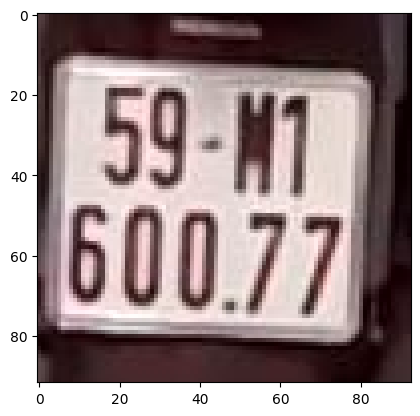

In [20]:
image = cv2.imread('darknet/data/images/moto_0153_02530_b.jpg')
boxes= detect.detect_image(model, image)
x,y,x1,y1 = int(boxes[0][0]), int(boxes[0][1]), int(boxes[0][2]), int(boxes[0][3])
numpy_image = image[y:y1, x:x1,:]
print(x,y, x1, y1)
imgage_ocr = Image.fromarray(np.uint8(numpy_image)).convert('RGB')
plt.imshow(imgage_ocr)

In [10]:
boxes[0][:5]

array([183.50214  ,  80.486206 , 276.14188  , 172.43459  ,   0.9931244],
      dtype=float32)